<a href="https://colab.research.google.com/github/Tamrika/Deep-Learning/blob/main/MusicGenreClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Genre Classification

In [ ]:
# Imports
import os
import librosa
import librosa.display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from tensorflow.python.keras import utils
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

Mount the drive location on Colab for I\O.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Processing Data

Plotting Mel Spectograms

In [ ]:
def plot_spectrogram(genre):
    '''
    This function takes in a list of genres and plots a mel spectrogram for one song 
    per genre in a 5 x 2 grid.
    '''
    
    # Defining the subplots
    fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (25,10))
    ax = ax.ravel() # Turning ax into a matrix to make it easier to work with

    # Looping through the list of genres
    for i, kind in enumerate(genre):
        
        # Reading in the first file from each genre
        y, sr = librosa.core.load(f'/content/gdrive/MyDrive/wav_files/{kind}.00000.wav')
        
        # Computing the mel spectrogram
        spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
        spect = librosa.power_to_db(spect, ref=np.max)
        
        # Displaying the mel spectrogram 
        librosa.display.specshow(spect, y_axis = 'mel', fmax = 8000, x_axis = 'time', ax = ax[i])
        ax[i].set_title(str(kind))

### Loading and Processing Audio Files

In [ ]:
def make_mel_spectrogram_df(directory):
    '''
    This function takes in a directory of audio files in .wav format, computes the
    mel spectrogram for each audio file, reshapes them so that they are all the 
    same size, flattens them, and stores them in a dataframe.
    
    Genre labels are also computed and added to the dataframe.
    
    Parameters:
    directory (int): a directory of audio files in .wav format
    
    Returns:
    df (DataFrame): a dataframe of flattened mel spectrograms and their 
    corresponding genre labels
    '''
    
    # Creating empty lists for mel spectrograms and labels
    labels = []
    mel_specs = []
    
    # Looping through each file in the directory
    for file in os.scandir(directory):
        
        # Loading in the audio file
        y, sr = librosa.core.load(file)
        
        # Extracting the label and adding it to the list
        label = str(file).split('.')[0][11:]
        labels.append(label)
        
        # Computing the mel spectrograms
        spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
        spect = librosa.power_to_db(spect, ref=np.max)
        
        # Adjusting the size to be 128 x 660
        if spect.shape[1] != 660:
            spect.resize(128,660, refcheck=False)
        
        # Flattening to fit into dataframe and adding to the list
        spect = spect.flatten()
        mel_specs.append(spect)
        #print('Memory Consumption (List): ',sys.getsizeof(mel_specs))

    # Converting the lists to arrays for stacking
    mel_specs = np.array(mel_specs)
    labels = np.array(labels).reshape(1000,1)

    # Returning the mel spectrograms and labels
    return mel_specs, labels

In [ ]:
# Using the above function to create a dataframe with all of the flattened mel spectrograms and genre labels

mel_specs, labels = make_mel_spectrogram_df('/content/gdrive/MyDrive/wav_files')
df = pd.DataFrame(mel_specs)
df['labels'] = labels

Since generating the spectograms can take time, we saved it in to a file, to load it each time.

In [ ]:
df.to_csv('/content/gdrive/MyDrive/genre_mel_specs_clean.csv', index=False)

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/genre_mel_specs_clean.csv')

A flattened view of the Mel Spectograms of the audio files. There are around 84,479 features per audio file.

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,84442,84443,84444,84445,84446,84447,84448,84449,84450,84451,84452,84453,84454,84455,84456,84457,84458,84459,84460,84461,84462,84463,84464,84465,84466,84467,84468,84469,84470,84471,84472,84473,84474,84475,84476,84477,84478,84479,labels,y
0,-19.039936,-31.215439,-28.724335,-33.466545,-37.974720,-38.017967,-43.290394,-43.284878,-40.745598,-46.368324,-44.794262,-47.693750,-42.450966,-34.403324,-45.978622,-41.566390,-44.236580,-50.910080,-47.179146,-40.567207,-43.81343,-45.006886,-45.586210,-40.354980,-32.871014,-40.954475,-43.906322,-50.673058,-49.033295,-49.494186,-38.231920,-44.663550,-47.840460,-48.439007,-47.784492,-47.617836,-49.790306,-50.011295,-46.286636,-44.130215,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jazz,6
1,-29.381193,-17.828934,-16.082321,-21.429170,-23.704780,-29.580908,-28.251745,-31.718090,-36.745407,-38.221283,-41.737850,-43.955067,-36.975353,-20.525597,-14.919221,-16.554745,-22.336693,-20.584965,-20.592157,-21.792213,-25.13155,-12.180038,-23.016186,-20.796227,-30.270826,-26.505362,-36.738995,-32.183937,-37.420662,-37.494846,-40.593792,-37.265068,-26.846375,-20.042677,-25.594904,-26.441830,-17.955648,-14.827248,-19.345654,-19.746159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,blues,1
2,-52.681557,-53.033882,-52.625343,-54.882698,-45.236115,-44.029240,-50.053173,-53.218080,-59.152702,-54.893375,-62.720757,-60.298935,-66.736040,-50.929030,-47.508102,-47.918350,-53.200146,-51.857197,-56.816242,-62.815773,-57.16902,-48.454998,-57.374970,-45.014214,-45.077720,-50.579390,-50.336770,-55.873100,-56.877136,-56.664180,-56.056450,-57.675537,-59.510147,-52.977910,-51.171867,-51.213600,-56.386772,-65.103880,-65.839676,-58.632145,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,blues,1
3,-29.582403,-40.890636,-53.688290,-58.673912,-56.272550,-57.726845,-42.948950,-41.516228,-43.822460,-51.094685,-54.818794,-61.444060,-64.527240,-55.785324,-56.355103,-60.959614,-64.754654,-47.228770,-45.024345,-53.807022,-55.99699,-65.052830,-60.920563,-60.778618,-56.241837,-47.446938,-45.018524,-45.011650,-45.146156,-49.535454,-47.449493,-58.321804,-67.567350,-64.546190,-54.057976,-46.753654,-44.532310,-47.973347,-50.307953,-47.196083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,blues,1
4,-45.674923,-52.609703,-57.399586,-54.405563,-53.770485,-34.826960,-31.622435,-36.683598,-44.000200,-44.389440,-49.239160,-52.135680,-51.809654,-52.104510,-56.543880,-52.509216,-60.341164,-55.151028,-49.106567,-49.455635,-58.44320,-50.386784,-54.598816,-53.035927,-36.981834,-27.787079,-35.285122,-43.720963,-45.721153,-52.107353,-49.745586,-49.901546,-50.816160,-51.726770,-63.069970,-58.721400,-46.258780,-49.942330,-50.208260,-53.305573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,blues,1


## Plot Mel spectogram

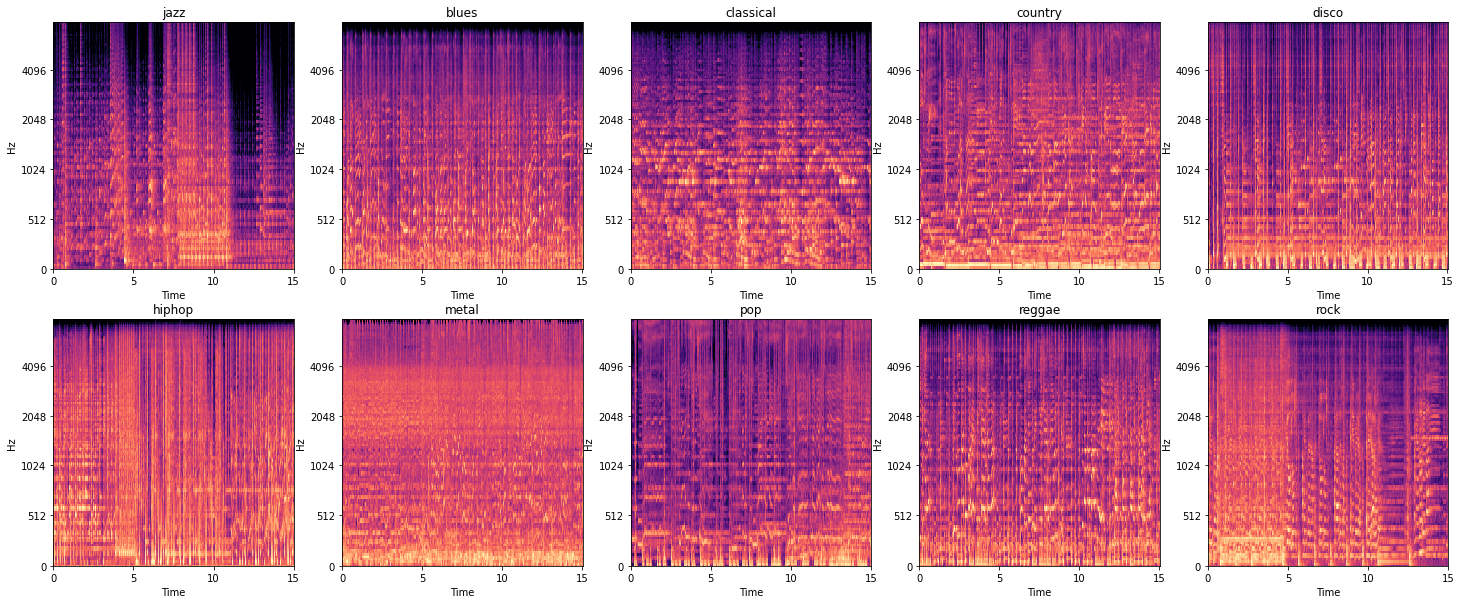

In [ ]:
# Creating a list of all the genres
genres = list(df['labels'].unique())

# Plotting spectrogram for each genre
plot_spectrogram(genres)

In [ ]:
# Dropping label columns to prepare our feature vector
specs = df.drop(columns=['labels', 'y'])

# Reshaping the arrays to their original "image" form
X = []
for i in range(len(df)):
    X.append(np.array(specs.iloc[i]).reshape(128,660))

X = np.array(X)

In [ ]:
# Converting labels to numeric values
labels = df['labels'].copy()

label_dict = {
    'jazz': 0,
    'reggae': 1,
    'rock': 2,
    'blues': 3,
    'hiphop': 4,
    'country': 5,
    'metal': 6,
    'classical': 7,
    'disco': 8,
    'pop': 9
}

y = labels.map(label_dict).values

### Train-Val-Test Split and Data Scaling

We will one-hot encode our target variable i.e. Audio category.

In [ ]:
y = to_categorical(y, 10)

Split the dataset in to Train and Test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, stratify=y, test_size=.3)

Further split the test set to get validation.

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=123, test_size=.5)

In [ ]:
print('Train Samples Shape: ', X_train.shape)
print('Validation Samples Shape: ', X_val.shape)
print('Test Samples Shape: ', X_test.shape)


Train Samples Shape:  (700, 128, 660)
Validation Samples Shape:  (150, 128, 660)
Test Samples Shape:  (150, 128, 660)


In [ ]:
#Calculating mean and standard deviation to scale
#X_train = (X_train - X_train.mean()) / X_train.std()
#X_test = (X_test - X_train.mean()) / X_train.std()

# Scaling our data to be between 0 and 1
min = X_train.min()

X_train /= min
X_val /= min
X_test /= min

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 128, 660, 1)
X_val = X_val.reshape(X_val.shape[0], 128, 660, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 660, 1)

# Applying Models

In [ ]:
def plotAccuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model loss')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train acc', 'val acc'], loc='upper right')
  plt.show()
  return

### Baseline Model - Simple Feed-forward Neural Network


In [ ]:
# Initializing a random seed for replication purposes
np.random.seed(123)

# Initiating an empty neural network
model = Sequential()

# Adding a flattened layer to input our image data
model.add(Flatten(input_shape = (128, 660, 1)))

# Adding a dense layer with 128 neurons
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

# Adding a dense layer with 128 neurons
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

# Adding a dense layer with 64 neurons
model.add(Dense(64, activation='relu'))

# Adding an output layer
model.add(Dense(10, activation='softmax'))

opt = Adam(0.001)

# Compiling our neural network
model.compile(loss='categorical_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

plot_model(model, show_shapes=True)

# Fitting our neural network
history = model.fit(X_train,
                    y_train, 
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    epochs=100)

Epoch 1/100
22/22 [==============================] - 3s 81ms/step - loss: 20.3678 - accuracy: 0.0895 - val_loss: 2.3020 - val_accuracy: 0.1200
Epoch 2/100
22/22 [==============================] - 2s 76ms/step - loss: 2.3024 - accuracy: 0.0896 - val_loss: 2.3023 - val_accuracy: 0.1200
Epoch 3/100
22/22 [==============================] - 2s 73ms/step - loss: 2.3031 - accuracy: 0.1130 - val_loss: 2.3017 - val_accuracy: 0.1200
Epoch 4/100
22/22 [==============================] - 2s 73ms/step - loss: 2.3032 - accuracy: 0.0796 - val_loss: 2.3020 - val_accuracy: 0.1200
Epoch 5/100
22/22 [==============================] - 2s 74ms/step - loss: 2.3019 - accuracy: 0.1120 - val_loss: 2.3019 - val_accuracy: 0.1200
Epoch 6/100
22/22 [==============================] - 2s 72ms/step - loss: 2.3024 - accuracy: 0.1105 - val_loss: 2.3019 - val_accuracy: 0.1200
Epoch 7/100
22/22 [==============================] - 2s 72ms/step - loss: 2.3035 - accuracy: 0.0916 - val_loss: 2.3021 - val_accuracy: 0.1200
Epoch

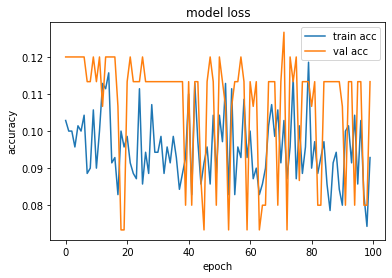

In [ ]:
plotAccuracy(history)

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test)

print('\nTest accuracy:', test_acc * 100)

5/5 [==============================] - 0s 19ms/step - loss: 2.3026 - accuracy: 0.0867

Test accuracy: 8.666666597127914


### Improved Model - Convolutional Neural Network

#### CNN Model 1

In [ ]:
# Initializing a random seed for replication purposes
np.random.seed(123)

# Initiating an empty neural network
cnn_model = Sequential(name='cnn_1')

# Adding convolutional block
cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     input_shape=(128,660,1)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding convolutional block
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='relu'))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,4)))


# Adding a flattened layer to input our image data
cnn_model.add(Flatten())

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(64, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.2))

# Adding an output layer
cnn_model.add(Dense(10, activation='softmax'))

#create a learning_rate schedule
lr_schedule = ExponentialDecay(
  initial_learning_rate=1e-4,
  decay_steps=1000,
  decay_rate=0.9)

#configuring and compiling the model
opt = Adam(learning_rate=lr_schedule)

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer= opt,
                  metrics=['accuracy'])



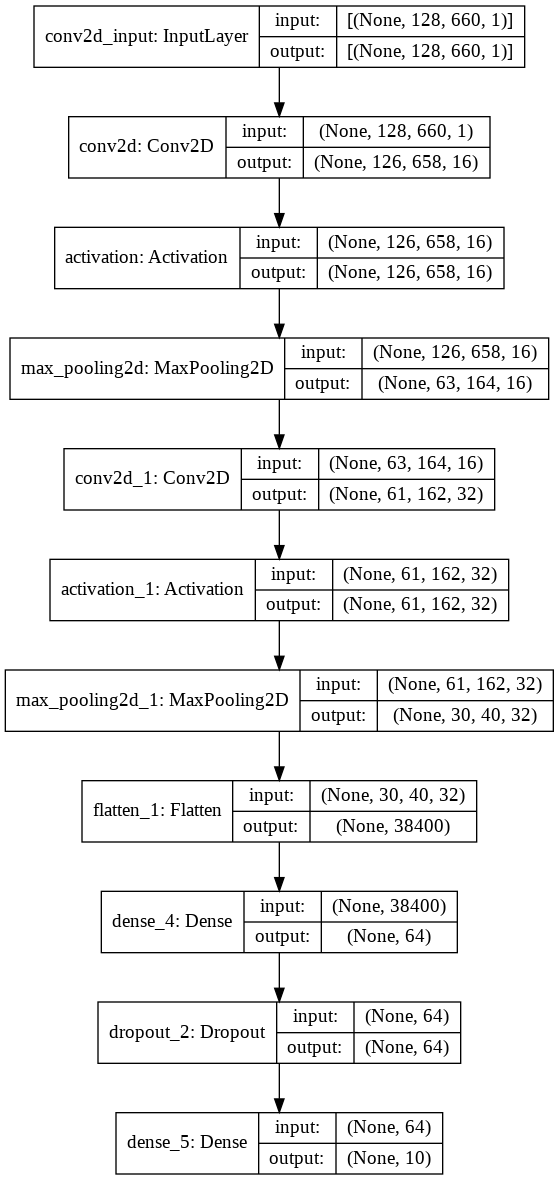

In [ ]:
plot_model(cnn_model, show_shapes=True)

In [ ]:
# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=64,
                        validation_data=(X_val, y_val),
                        epochs=200)

Epoch 1/200
11/11 [==============================] - 26s 2s/step - loss: 2.3174 - accuracy: 0.1251 - val_loss: 2.2995 - val_accuracy: 0.0733
Epoch 2/200
11/11 [==============================] - 24s 2s/step - loss: 2.2986 - accuracy: 0.1184 - val_loss: 2.2979 - val_accuracy: 0.0867
Epoch 3/200
11/11 [==============================] - 25s 2s/step - loss: 2.2965 - accuracy: 0.1035 - val_loss: 2.2914 - val_accuracy: 0.1200
Epoch 4/200
11/11 [==============================] - 24s 2s/step - loss: 2.2948 - accuracy: 0.1133 - val_loss: 2.2846 - val_accuracy: 0.2067
Epoch 5/200
11/11 [==============================] - 24s 2s/step - loss: 2.2885 - accuracy: 0.1565 - val_loss: 2.2796 - val_accuracy: 0.1333
Epoch 6/200
11/11 [==============================] - 24s 2s/step - loss: 2.2832 - accuracy: 0.1295 - val_loss: 2.2758 - val_accuracy: 0.2133
Epoch 7/200
11/11 [==============================] - 25s 2s/step - loss: 2.2794 - accuracy: 0.1329 - val_loss: 2.2691 - val_accuracy: 0.1867
Epoch 8/200
1

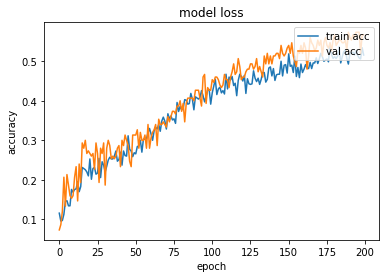

In [ ]:
plotAccuracy(history)

In [ ]:
test_loss, test_acc = cnn_model.evaluate(X_test,  y_test)

print('\nTest accuracy:', test_acc * 100)

5/5 [==============================] - 2s 335ms/step - loss: 1.4368 - accuracy: 0.5200

Test accuracy: 51.99999809265137


#### CNN Model 2

Added more convolutional blocks with batch normalization and increased regularization factor.

In [ ]:
# Initializing a random seed for replication purposes
np.random.seed(123)

# Initiating an empty neural network
cnn_model = Sequential(name='cnn_2')

# Adding convolutional block
cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     input_shape=(128,660,1)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding convolutional block
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding convolutional block
cnn_model.add(Conv2D(filters=64,
                     kernel_size=(3,3),
                     activation='relu'))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding a flattened layer to input our image data
cnn_model.add(Flatten())

# Adding a dense layer with 256 neurons
cnn_model.add(Dense(256, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.5))

# Adding a dense layer with 128 neurons
cnn_model.add(Dense(128, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.5))

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(64, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.2))

# Adding an output layer
cnn_model.add(Dense(10, activation='softmax'))

#create a learning_rate schedule
lr_schedule = ExponentialDecay(
  initial_learning_rate=1e-4,
  decay_steps=1000,
  decay_rate=0.9)

#configuring and compiling the model
opt = Adam(learning_rate=lr_schedule)

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer= opt,
                  metrics=['accuracy'])


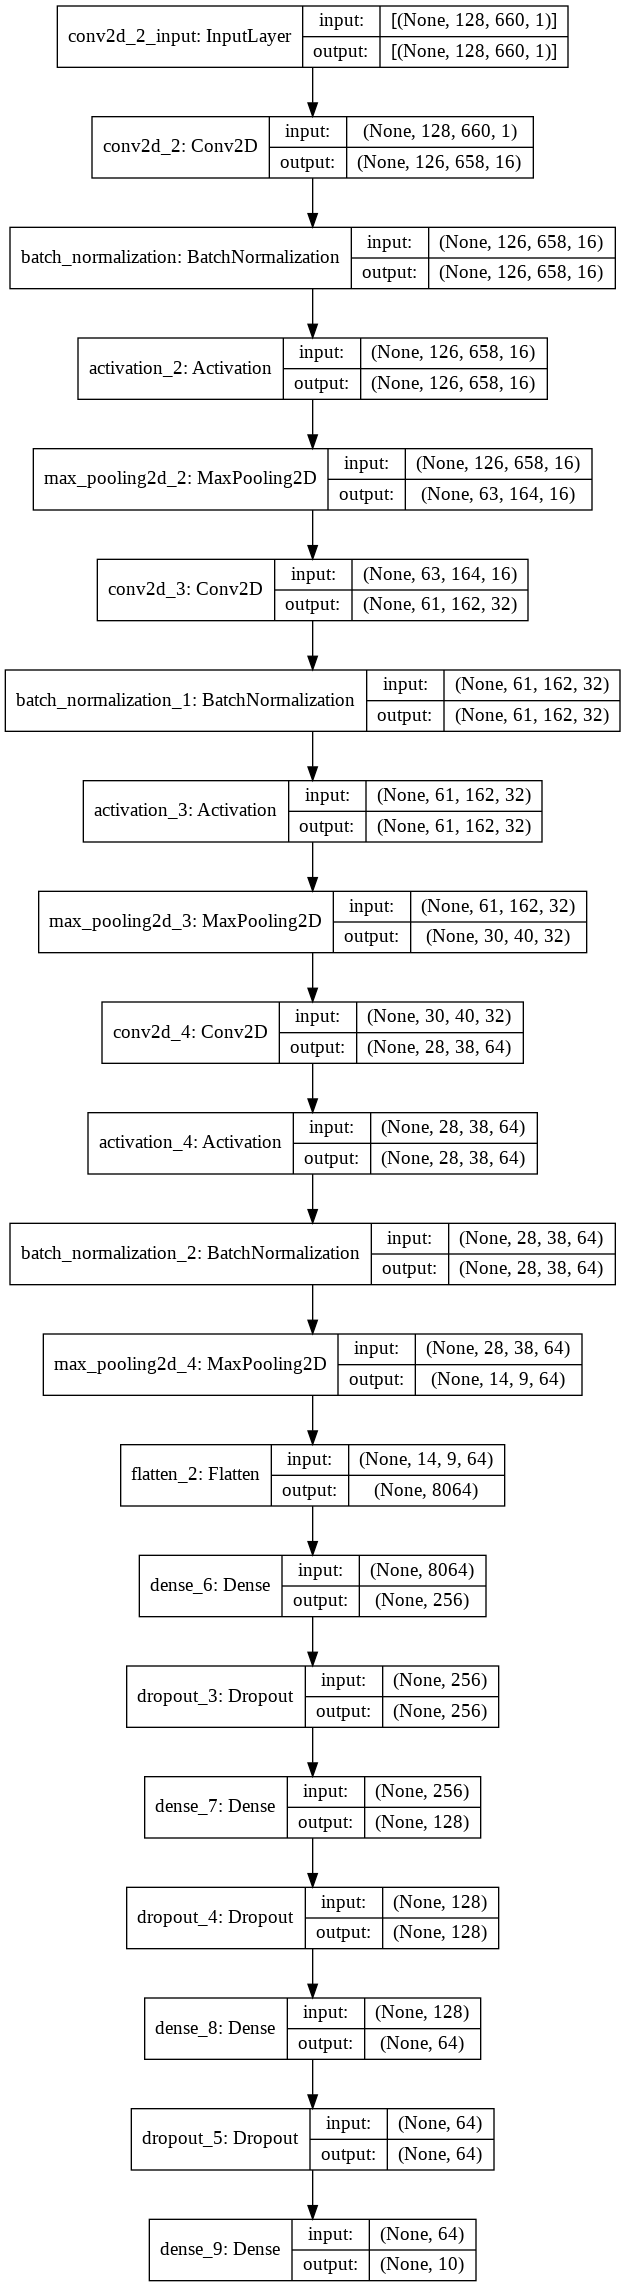

In [ ]:
plot_model(cnn_model, show_shapes=True)

In [ ]:
# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=64,
                        validation_data=(X_val, y_val),
                        epochs=200)

Epoch 1/200
11/11 [==============================] - 44s 4s/step - loss: 4.1471 - accuracy: 0.1146 - val_loss: 2.2995 - val_accuracy: 0.1133
Epoch 2/200
11/11 [==============================] - 43s 4s/step - loss: 2.9165 - accuracy: 0.1540 - val_loss: 2.3553 - val_accuracy: 0.1067
Epoch 3/200
11/11 [==============================] - 42s 4s/step - loss: 2.5696 - accuracy: 0.1643 - val_loss: 2.4606 - val_accuracy: 0.1067
Epoch 4/200
11/11 [==============================] - 43s 4s/step - loss: 2.3023 - accuracy: 0.1952 - val_loss: 2.5967 - val_accuracy: 0.1067
Epoch 5/200
11/11 [==============================] - 42s 4s/step - loss: 2.2605 - accuracy: 0.1928 - val_loss: 2.7701 - val_accuracy: 0.1067
Epoch 6/200
11/11 [==============================] - 42s 4s/step - loss: 2.1453 - accuracy: 0.2492 - val_loss: 2.8893 - val_accuracy: 0.1067
Epoch 7/200
11/11 [==============================] - 43s 4s/step - loss: 2.0484 - accuracy: 0.2495 - val_loss: 3.0103 - val_accuracy: 0.1067
Epoch 8/200
1

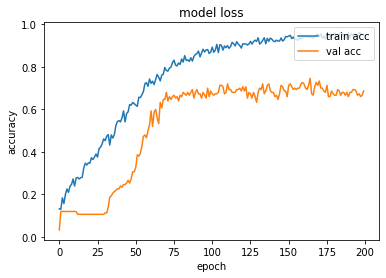

In [ ]:
plotAccuracy(history)

In [ ]:
test_loss, test_acc = cnn_model.evaluate(X_test,  y_test)

print('\nTest accuracy:', test_acc * 100)

5/5 [==============================] - 0s 15ms/step - loss: 1.5569 - accuracy: 0.6467

Test accuracy: 64.66666460037231


#### CNN Model 3

Deeper model, with Global Average Pooling. Training with more epochs and early stopping.

In [ ]:
# Initializing a random seed for replication purposes
np.random.seed(123)

# Initiating an empty neural network
cnn_model = Sequential(name='cnn_3')

# Adding convolutional block
cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     input_shape=(128,660,1)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding convolutional block
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding convolutional block
cnn_model.add(Conv2D(filters=64,
                     kernel_size=(3,3),
                     activation='relu'))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding convolutional block
cnn_model.add(Conv2D(filters=128,
                     kernel_size=(3,3),
                     activation='relu'))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding a GlobalAveragePooling2D layer to input our image data
cnn_model.add(GlobalAveragePooling2D())

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(128, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.5))

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(64, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.2))

# Adding an output layer
cnn_model.add(Dense(10, activation='softmax'))

#create a learning_rate schedule
lr_schedule = ExponentialDecay(
  initial_learning_rate=1e-4,
  decay_steps=1000,
  decay_rate=0.9)

#configuring and compiling the model
opt = Adam(learning_rate=lr_schedule)

#callback for early stopping
#callback = EarlyStopping(monitor='val_accuracy', patience=50, min_delta=1e-3, restore_best_weights=True)

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer= opt,
                  metrics=['accuracy'])


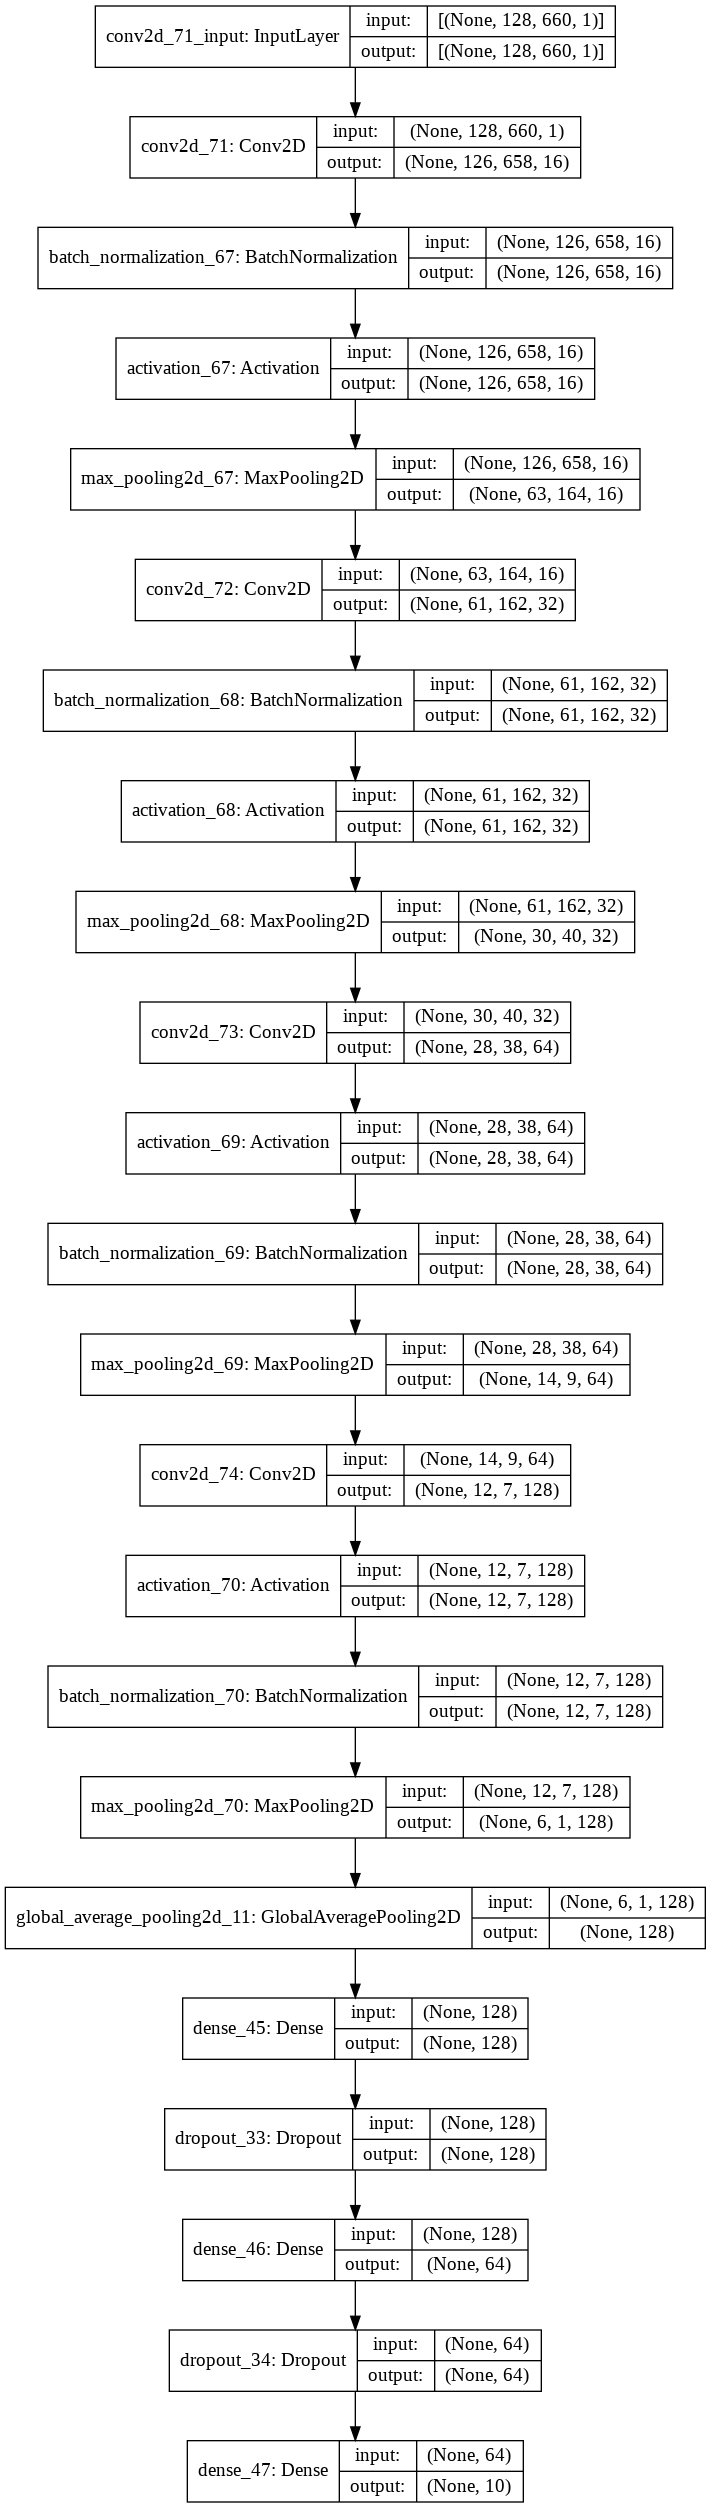

In [ ]:
plot_model(cnn_model, show_shapes=True)

In [ ]:
# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=64,
                        validation_data=(X_val, y_val),
                        epochs=500)
                        #callbacks= callback)

Epoch 1/500
11/11 [==============================] - 2s 121ms/step - loss: 4.1154 - accuracy: 0.1041 - val_loss: 2.3012 - val_accuracy: 0.1067
Epoch 2/500
11/11 [==============================] - 1s 87ms/step - loss: 3.0389 - accuracy: 0.1432 - val_loss: 2.3017 - val_accuracy: 0.0200
Epoch 3/500
11/11 [==============================] - 1s 87ms/step - loss: 2.5873 - accuracy: 0.2080 - val_loss: 2.3063 - val_accuracy: 0.1067
Epoch 4/500
11/11 [==============================] - 1s 87ms/step - loss: 2.3150 - accuracy: 0.2221 - val_loss: 2.3149 - val_accuracy: 0.1067
Epoch 5/500
11/11 [==============================] - 1s 89ms/step - loss: 2.2614 - accuracy: 0.2413 - val_loss: 2.3243 - val_accuracy: 0.0667
Epoch 6/500
11/11 [==============================] - 1s 89ms/step - loss: 2.1186 - accuracy: 0.2355 - val_loss: 2.3364 - val_accuracy: 0.1533
Epoch 7/500
11/11 [==============================] - 1s 87ms/step - loss: 2.0728 - accuracy: 0.2601 - val_loss: 2.3543 - val_accuracy: 0.1067
Epoch

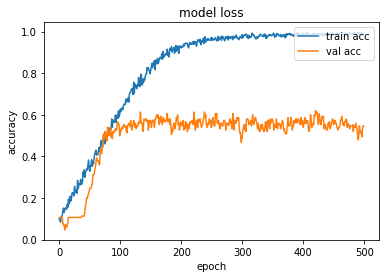

In [ ]:
plotAccuracy(history)

In [ ]:
test_loss, test_acc = cnn_model.evaluate(X_test,  y_test)

print('\nTest accuracy:', test_acc * 100)

5/5 [==============================] - 0s 14ms/step - loss: 3.6140 - accuracy: 0.4067

Test accuracy: 40.66666662693024
